In [1]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold, train_test_split

c:\Users\prath\anaconda3\envs\spine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rd = './data'

In [3]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

OUTPUT_DIR = f'rsna24-results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# N_WORKERS = os.cpu_count() 
N_WORKERS = 0
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [512, 512]
IN_CHANS = 10
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 20 if NOT_DEBUG else 2
MODEL_NAME = "edgenext_base.in21k_ft_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 1e-3 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

In [4]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

In [6]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [7]:
df = df.fillna(-100)

In [8]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

C:\Users\prath\AppData\Local\Temp\ipykernel_13036\1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
_, df_subset = train_test_split(df, test_size=0.2, random_state=SEED)

In [10]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

In [11]:
class RSNA25DDataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.phase = phase
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        views = {
            'sagittal_t1': np.zeros((512, 512, 10), dtype=np.float32),
            'sagittal_t2_stir': np.zeros((512, 512, 10), dtype=np.float32),
            'axial_t2': np.zeros((512, 512, 10), dtype=np.float32)
        }
        
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.float32)
        
        # Load Sagittal T1
        for i in range(10):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(p).convert('L')
                views['sagittal_t1'][..., i] = np.array(img) / 255.0
            except:
                pass
            
        # Load Sagittal T2/STIR
        for i in range(10):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(p).convert('L')
                views['sagittal_t2_stir'][..., i] = np.array(img) / 255.0
            except:
                pass
            
        # Load Axial T2
        axt2 = sorted(glob(f'./cvt_png/{st_id}/Axial T2/*.png'))
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2) + 0.0001
                
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                p = axt2[max(0, int((j-0.5001).round()))]
                img = Image.open(p).convert('L')
                views['axial_t2'][..., i] = np.array(img) / 255.0
            except:
                pass
            
        assert any(np.sum(view) > 0 for view in views.values())
            
        if self.transform is not None:
            # Apply the same transform to all slices of each view
            for key in views:
                transformed = []
                for i in range(views[key].shape[2]):
                    augmented = self.transform(image=views[key][..., i])
                    transformed.append(augmented['image'])
                views[key] = np.stack(transformed, axis=-1)

        # Convert to torch tensors and change to (C, H, W) format
        for key in views:
            views[key] = torch.from_numpy(views[key].transpose(2, 0, 1)).float()
                
        return views, torch.from_numpy(label).float()

# Define augmentations
def get_transforms(phase, img_size):
    list_transforms = []
    if phase == "train":
        list_transforms.extend([
            A.RandomResizedCrop(height=img_size[0], width=img_size[1], scale=(0.8, 1), p=1),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.75),
        ])
    
    list_transforms.extend([
        A.Resize(img_size[0], img_size[1]),
        A.Normalize(mean=[0.5], std=[0.5]),
    ])
    
    return A.Compose(list_transforms)

# Usage
img_size = (512, 512)
transforms_train = get_transforms('train', img_size)
transforms_val = get_transforms('val', img_size)

In [12]:
# transforms_train = A.Compose([
#     A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
#     A.OneOf([
#         A.MotionBlur(blur_limit=5),
#         A.MedianBlur(blur_limit=5),
#         A.GaussianBlur(blur_limit=5),
#         A.GaussNoise(var_limit=(5.0, 30.0)),
#     ], p=AUG_PROB),
#     A.OneOf([
#         A.OpticalDistortion(distort_limit=1.0),
#         A.GridDistortion(num_steps=5, distort_limit=1.),
#         A.ElasticTransform(alpha=3),
#     ], p=AUG_PROB),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
#     A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
#     A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
#     A.Normalize(mean=0.5, std=0.5)
# ])

# transforms_val = A.Compose([
#     A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
#     A.Normalize(mean=0.5, std=0.5)
# ])

# if not NOT_DEBUG or not AUG:
#     transforms_train = transforms_val

In [13]:
class RSNA25DModel(nn.Module):
    def __init__(self, model_name, in_c=10, n_classes=75, pretrained=True):
        super().__init__()
        
        # Create separate branches for each view
        self.sagittal_t1_branch = self._create_branch(model_name, in_c, pretrained)
        self.sagittal_t2_stir_branch = self._create_branch(model_name, in_c, pretrained)
        self.axial_t2_branch = self._create_branch(model_name, in_c, pretrained)
        
        # Get the feature dimension of the base model
        with torch.no_grad():
            dummy_input = torch.randn(1, in_c, 224, 224)  # Adjust size if needed
            feature_dim = self.sagittal_t1_branch(dummy_input).shape[1]
        
        # Create a fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(feature_dim * 3, feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        # Final classification layer
        self.classifier = nn.Linear(feature_dim, n_classes)

    def _create_branch(self, model_name, in_c, pretrained):
        return timm.create_model(
            model_name,
            pretrained=pretrained,
            features_only=False,
            in_chans=in_c,
            num_classes=0,  # Remove the classification head
            global_pool='avg'
        )

    def forward(self, x):
        # x is expected to be a dictionary with keys 'sagittal_t1', 'sagittal_t2_stir', 'axial_t2'
        f_sagittal_t1 = self.sagittal_t1_branch(x['sagittal_t1'])
        f_sagittal_t2_stir = self.sagittal_t2_stir_branch(x['sagittal_t2_stir'])
        f_axial_t2 = self.axial_t2_branch(x['axial_t2'])
        
        # Concatenate features from all branches
        combined_features = torch.cat([f_sagittal_t1, f_sagittal_t2_stir, f_axial_t2], dim=1)
        
        # Fuse features
        fused_features = self.fusion(combined_features)
        
        # Final classification
        output = self.classifier(fused_features).float()
        
        return output

In [14]:
def visualize_batch(batch, num_samples=4):
    views, labels = batch
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        for j, view_name in enumerate(['sagittal_t1', 'sagittal_t2_stir', 'axial_t2']):
            # Select a middle slice (e.g., 5th out of 10)
            slice_img = views[view_name][i, 5].numpy()
            
            axs[i, j].imshow(slice_img, cmap='gray')
            axs[i, j].set_title(f'Sample {i+1}, {view_name}')
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

C:\Users\prath\AppData\Local\Temp\ipykernel_13036\2788836955.py:1: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half)
C:\Users\prath\AppData\Local\Temp\ipykernel_13036\2788836955.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)


##############################
start fold0
##############################
316 79


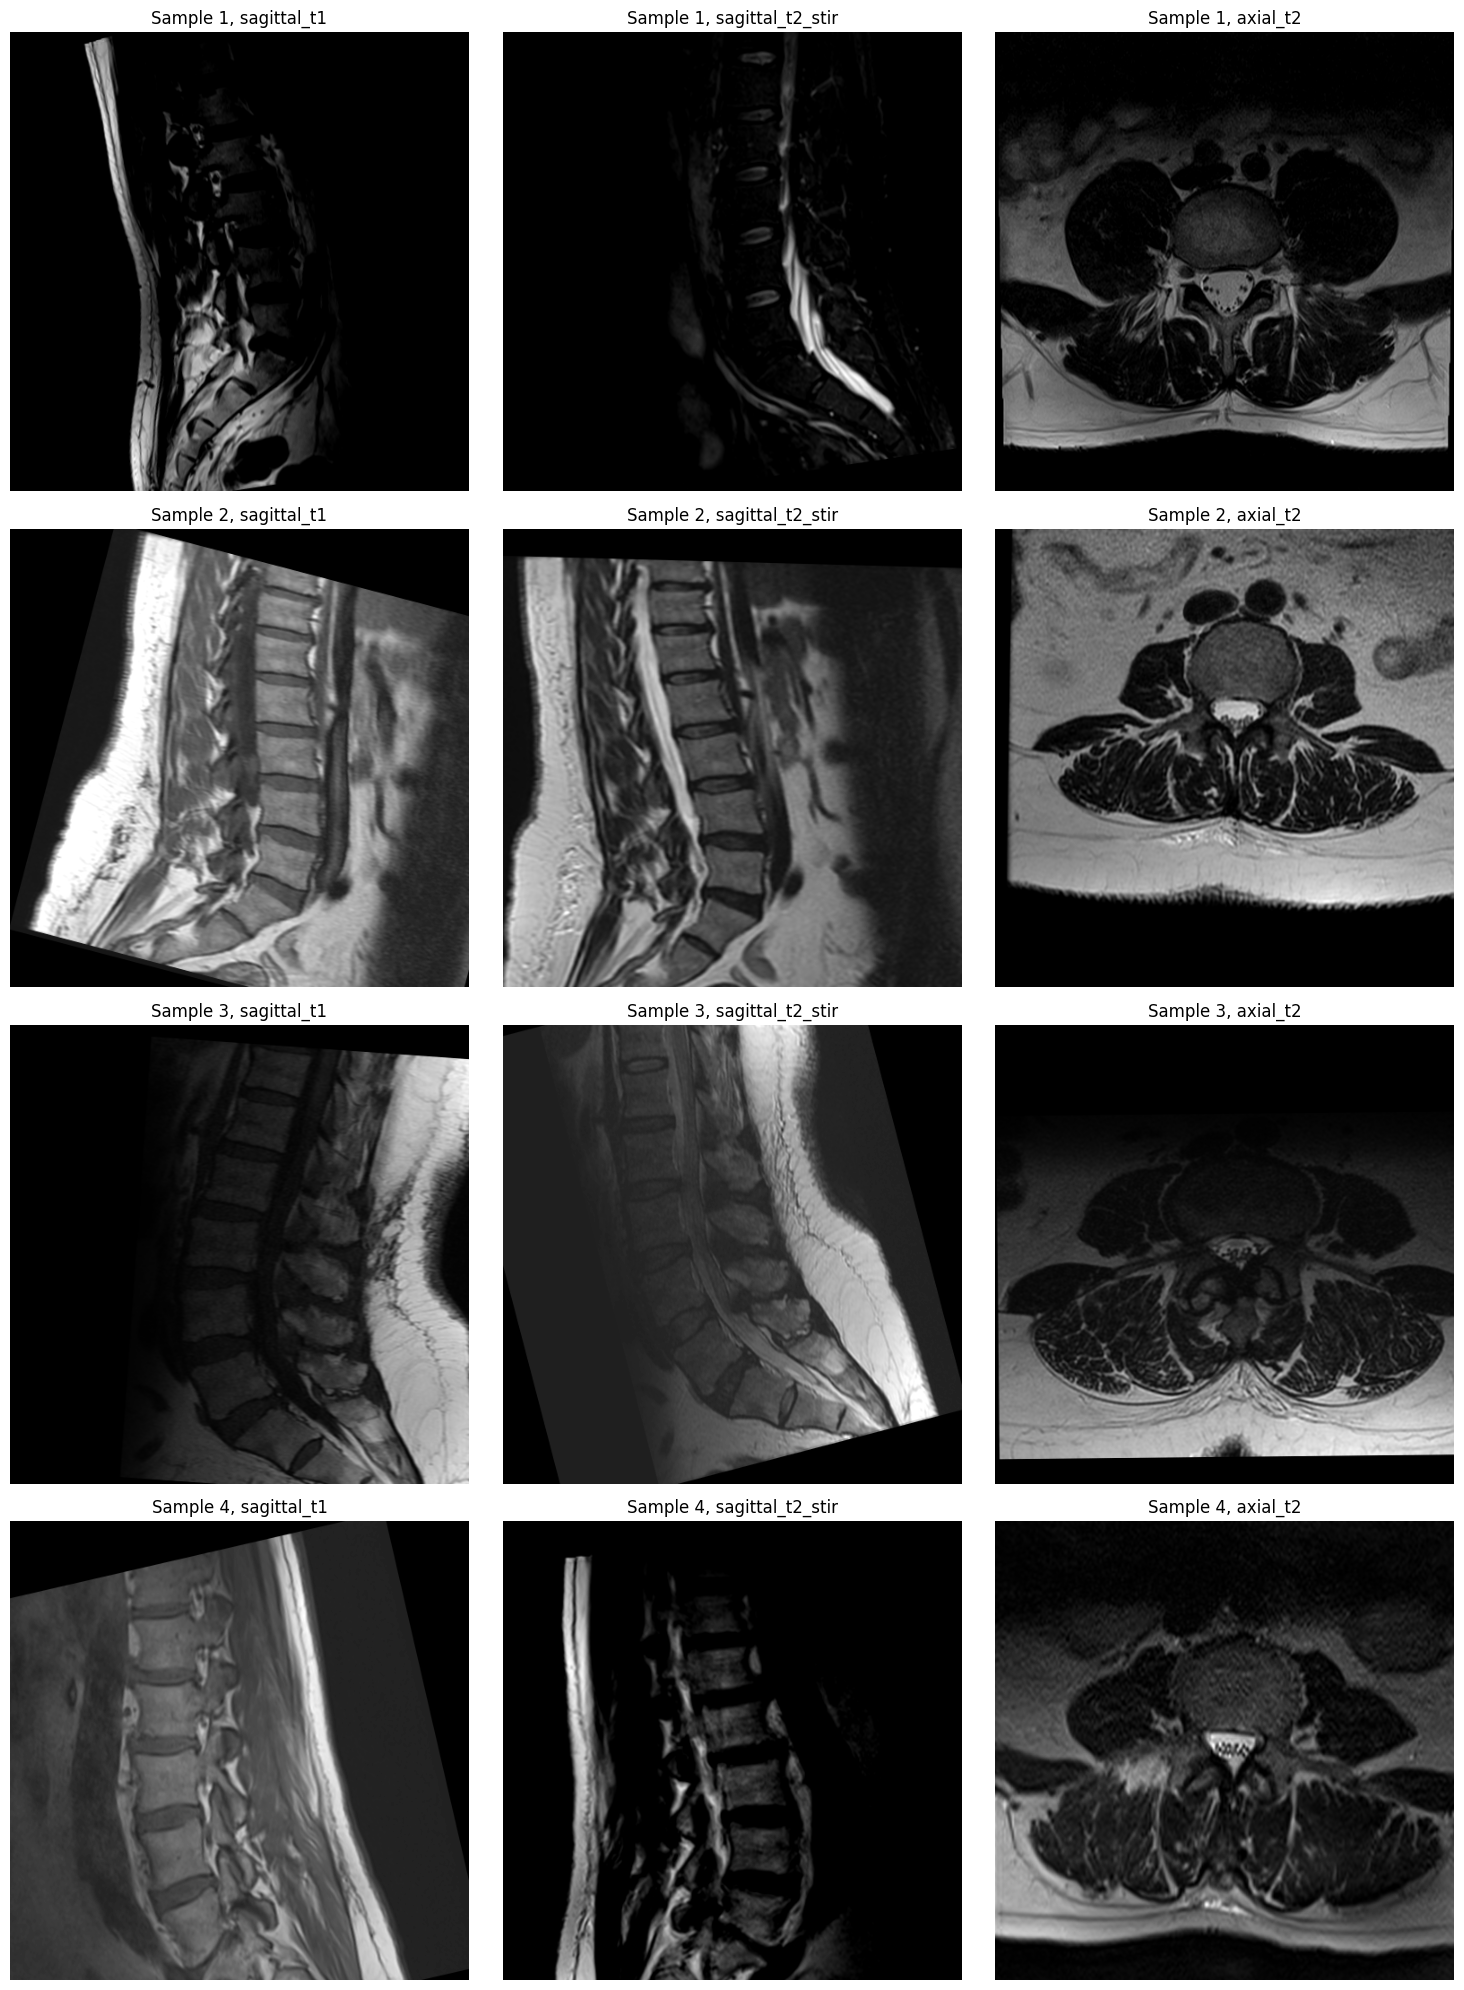

start epoch 1


 32%|███▏      | 6/19 [08:33<11:34, 53.40s/it, loss=1.069639, lr=1.053e-04]   

In [15]:
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df_subset)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))
    df_train = df_subset.iloc[trn_idx]
    df_valid = df_subset.iloc[val_idx]

    train_ds = RSNA25DDataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )
    
    train_iter = iter(train_dl)
    batch = next(train_iter)
    visualize_batch(batch)

    valid_ds = RSNA25DDataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=BATCH_SIZE*2,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = RSNA25DModel(MODEL_NAME, in_c=IN_CHANS, n_classes=N_CLASSES, pretrained=True)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup_steps,
                                                num_training_steps=num_total_steps,
                                                num_cycles=num_cycles)

    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    criterion2 = nn.CrossEntropyLoss(weight=weights)

    best_loss = 1.2
    best_wll = 1.2
    es_step = 0

    for epoch in range(1, EPOCHS+1):
        print(f'start epoch {epoch}')
        model.train()
        total_loss = 0
        with tqdm(train_dl, leave=True) as pbar:
            optimizer.zero_grad()
            for idx, (x, t) in enumerate(pbar):  
                x = {k: v.to(device) for k, v in x.items()}
                t = t.long().to(device)
                
                with autocast:
                    loss = 0
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        loss = loss + criterion(pred, gt) / N_LABELS
                        
                    total_loss += loss.item()
                    if GRAD_ACC > 1:
                        loss = loss / GRAD_ACC
    
                if not math.isfinite(loss):
                    print(f"Loss is {loss}, stopping training")
                    sys.exit(1)
    
                pbar.set_postfix(
                    OrderedDict(
                        loss=f'{loss.item()*GRAD_ACC:.6f}',
                        lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                    )
                )
                scaler.scale(loss).backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)
                
                if (idx + 1) % GRAD_ACC == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    if scheduler is not None:
                        scheduler.step()                    
    
        train_loss = total_loss/len(train_dl)
        print(f'train_loss:{train_loss:.6f}')

        total_loss = 0
        y_preds = []
        labels = []
        
        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    x = {k: v.to(device) for k, v in x.items()}
                    t = t.long().to(device)
                        
                    with autocast:
                        loss = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
 
                            loss = loss + criterion(pred, gt) / N_LABELS
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
                        
                        total_loss += loss.item()   
    
        val_loss = total_loss/len(valid_dl)
        
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = criterion2(y_preds, labels)
        
        print(f'val_loss:{val_loss:.6f}, val_wll:{val_wll:.6f}')

        if val_loss < best_loss or val_wll < best_wll:
            es_step = 0

            if device!='cuda:0':
                model.to('cuda:0')                
                
            if val_loss < best_loss:
                print(f'epoch:{epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss
                
            if val_wll < best_wll:
                print(f'epoch:{epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
            
            if device!='cuda:0':
                model.to(device)
            
        else:
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('early stopping')
                break